In [1]:
"""
Phase 1: Preprocessing Pipeline for PhysioNet Motor Movement/Imagery Database
Focuses on Task 1 (left hand) and Task 2 (right hand) motor imagery in beta band.
"""

import numpy as np
import mne
from mne.io import read_raw_edf
from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


class PhysioNetPreprocessor:
    """
    Preprocessing pipeline for PhysioNet Motor Imagery Database.
    
    Pipeline Steps:
    1. Channel Selection (9 sensorimotor channels)
    2. Temporal Filtering (13-30 Hz beta band - PD primary biomarker)
    3. Spatial Filtering (Common Average Reference)
    4. Artifact Removal (±100 μV threshold)
    5. Epoching (2-second windows before movement onset)
    6. Baseline Correction
    """
    
    def __init__(self, data_dir=r"C:\Users\fibof\Downloads\physionet"):
        """
        Initialize preprocessor.
        
        Parameters:
        -----------
        data_dir : str
            Path to PhysioNet dataset directory
        """
        self.data_dir = Path(data_dir)
        
        # Channel configuration - sensorimotor channels over motor cortex
        # PhysioNet uses standard 10-20 system with these available channels
        # We'll select C3, Cz, C4 (primary motor cortex) and surrounding channels
        self.sensorimotor_channels = ['FC3..', 'FC1..', 'FCz..', 'FC2..', 'FC4..',
                                      'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..',
                                      'CP3..', 'CP1..', 'CPz..', 'CP2..', 'CP4..']
        # We'll let MNE find which ones exist and select the best available
        
        # Beta band filtering (13-30 Hz) - PD primary biomarker frequency
        self.sfreq = 160  # PhysioNet sampling frequency
        self.lowcut = 13.0   # Beta band lower bound
        self.highcut = 30.0  # Beta band upper bound
        self.notch_freq = 60.0  # Remove electrical line noise
        
        # Epoching parameters
        self.epoch_tmin = -2.0  # 2 seconds before movement onset
        self.epoch_tmax = 0.0   # Movement onset
        self.baseline_tmin = -2.0  # Baseline must be within epoch window
        self.baseline_tmax = -1.5  # Use first 0.5 seconds as baseline
        
        # Artifact rejection threshold
        self.reject_threshold = 100e-6  # 100 μV
        
    def get_subject_files(self, subject_id):
        """
        Get file paths for a specific subject's task 1 and task 2.
        
        Task 1 (Motor Imagery):
        - Runs 3, 7, 11: Left vs Right hand motor imagery
        
        Task 2 (Motor Execution):
        - Runs 4, 8, 12: Left vs Right hand actual movement
        
        Parameters:
        -----------
        subject_id : int
            Subject ID (1-50)
            
        Returns:
        --------
        files : list
            List of (edf_path, event_path) tuples
        """
        subject_str = f'S{subject_id:03d}'
        
        # Task 1: Motor imagery runs (3, 7, 11)
        # Task 2: Motor execution runs (4, 8, 12)
        runs = [3, 7, 11, 4, 8, 12]  # Both tasks
        
        files = []
        for run in runs:
            edf_file = self.data_dir / f'{subject_str}R{run:02d}.edf'
            event_file = self.data_dir / f'{subject_str}R{run:02d}.edf.event'
            
            if edf_file.exists() and event_file.exists():
                files.append((edf_file, event_file))
            else:
                print(f"Warning: Missing files for {subject_str}R{run:02d}")
        
        return files
    
    def load_subject_data(self, subject_id):
        """
        Load EEG data for a specific subject (tasks 1 and 2).
        
        Task 1: Motor imagery (runs 3, 7, 11)
        Task 2: Motor execution (runs 4, 8, 12)
        
        Parameters:
        -----------
        subject_id : int
            Subject ID (1-50)
            
        Returns:
        --------
        raw_list : list
            List of (raw, event_file_path) tuples
        """
        files = self.get_subject_files(subject_id)
        
        if not files:
            raise FileNotFoundError(f"No data found for subject {subject_id}")
        
        raw_list = []
        for edf_path, event_path in files:
            # Load EDF file
            raw = read_raw_edf(edf_path, preload=True, verbose=False)
            raw_list.append((raw, event_path))
        
        return raw_list
    
    def select_channels(self, raw):
        """
        Select sensorimotor channels covering motor cortex.
        
        PhysioNet dataset has 64 channels with names like "FC3..", "C3..", etc.
        We want channels over the motor cortex (C3, Cz, C4 and surrounding).
        
        Parameters:
        -----------
        raw : mne.io.Raw
            Raw EEG data
            
        Returns:
        --------
        raw : mne.io.Raw
            Data with selected channels only
        """
        # Get all available channel names
        available_channels = raw.ch_names
        print(f"Available channels: {available_channels[:10]}... (showing first 10)")
        
        # Define desired sensorimotor channels (in priority order)
        # Primary motor cortex and surrounding areas
        desired_channels = [
            'C3..', 'Cz..', 'C4..',      # Primary motor cortex (most important)
            'C1..', 'C2..', 'C5..', 'C6..',  # Additional central channels
            'FC3..', 'FCz..', 'FC4..',   # Frontal-central
            'FC1..', 'FC2..',
            'CP3..', 'CPz..', 'CP4..',   # Central-parietal
            'CP1..', 'CP2..'
        ]
        
        # Find which desired channels are actually available
        selected = []
        for ch in desired_channels:
            if ch in available_channels:
                selected.append(ch)
        
        # If we have fewer than 9 channels, add more central/motor channels
        if len(selected) < 9:
            # Add any other C or CP channels we might have missed
            for ch in available_channels:
                if (ch.startswith('C') or ch.startswith('FC') or ch.startswith('CP')) and ch not in selected:
                    selected.append(ch)
                    if len(selected) >= 9:
                        break
        
        # Take the first 9 channels (or all if less than 9)
        selected = selected[:9]
        
        if len(selected) == 0:
            raise ValueError("No sensorimotor channels found in the data!")
        
        # Select these channels
        raw.pick_channels(selected, ordered=True)
        
        print(f"Selected {len(raw.ch_names)} channels: {raw.ch_names}")
        return raw
    
    def apply_temporal_filtering(self, raw):
        """
        Apply beta band filter (13-30 Hz) and notch filter (60 Hz).
        
        Beta band is the primary biomarker for Parkinson's disease.
        
        Parameters:
        -----------
        raw : mne.io.Raw
            Raw EEG data
            
        Returns:
        --------
        raw : mne.io.Raw
            Filtered data
        """
        # Bandpass filter: 13-30 Hz (beta band - PD primary biomarker)
        raw.filter(self.lowcut, self.highcut, fir_design='firwin', 
                   verbose=False)
        
        # Notch filter: 60 Hz (remove electrical line noise)
        raw.notch_filter(self.notch_freq, verbose=False)
        
        print(f"Applied beta band filter: {self.lowcut}-{self.highcut} Hz")
        print(f"Applied notch filter: {self.notch_freq} Hz")
        
        return raw
    
    def apply_spatial_filtering(self, raw):
        """
        Apply Common Average Reference (CAR) to reduce common noise.
        
        Parameters:
        -----------
        raw : mne.io.Raw
            Raw EEG data
            
        Returns:
        --------
        raw : mne.io.Raw
            Spatially filtered data
        """
        raw.set_eeg_reference('average', projection=False, verbose=False)
        print("Applied Common Average Reference (CAR)")
        return raw
    
    def read_event_file(self, event_file_path):
        """
        Read events from .edf.event file.
        
        PhysioNet .edf.event files are in EDF+ Annotations format (binary).
        We need to parse the annotations from the EDF file itself.
        
        Parameters:
        -----------
        event_file_path : Path
            Path to .edf.event file (actually the EDF file with annotations)
            
        Returns:
        --------
        events_list : list
            List of (time, duration, event_type) tuples
        """
        events_list = []
        
        try:
            # The .edf.event file is actually an EDF file with annotations
            # Let's read it using MNE
            raw_event = read_raw_edf(str(event_file_path), preload=False, verbose=False)
            
            # Extract annotations
            annotations = raw_event.annotations
            
            for annot in annotations:
                onset = annot['onset']
                duration = annot['duration']
                description = annot['description']
                
                # The description should be T0, T1, or T2
                if description in ['T0', 'T1', 'T2']:
                    events_list.append((onset, duration, description))
            
        except Exception as e:
            print(f"Warning: Could not read event file as EDF: {e}")
            print("Attempting to parse as text file...")
            
            # Fallback: try to read as text
            try:
                with open(event_file_path, 'r', encoding='latin-1', errors='ignore') as f:
                    content = f.read()
                    # Look for patterns like "T0", "T1", "T2"
                    import re
                    # This is a simplified parser - may need adjustment
                    lines = content.split('\n')
                    for line in lines:
                        if 'T0' in line or 'T1' in line or 'T2' in line:
                            # Try to extract the event type
                            if 'T0' in line:
                                events_list.append((0, 0, 'T0'))
                            elif 'T1' in line:
                                events_list.append((0, 0, 'T1'))
                            elif 'T2' in line:
                                events_list.append((0, 0, 'T2'))
            except:
                pass
        
        return events_list
    
    def events_to_mne_format(self, events_list, sfreq):
        """
        Convert event list to MNE events array format.
        
        Parameters:
        -----------
        events_list : list
            List of (time, duration, event_type) tuples
        sfreq : float
            Sampling frequency
            
        Returns:
        --------
        events : np.ndarray
            MNE events array (n_events, 3) with [sample, 0, event_id]
        event_id : dict
            Mapping of event names to IDs
        """
        event_id = {
            'rest': 1,
            'left': 2,
            'right': 3
        }
        
        # Map event types to IDs
        event_type_to_id = {
            'T0': 1,  # rest
            'T1': 2,  # left
            'T2': 3   # right
        }
        
        events = []
        for time_offset, duration, event_type in events_list:
            # Convert time to sample number
            sample = int(time_offset * sfreq)
            
            # Get event ID
            if event_type in event_type_to_id:
                event_code = event_type_to_id[event_type]
                events.append([sample, 0, event_code])
        
        return np.array(events, dtype=int), event_id
    def extract_epochs(self, raw, event_file_path):
        """
        Extract 2-second epochs before movement onset.
        
        Try multiple methods to extract events:
        1. From annotations in the main EDF file
        2. From the separate .edf.event file
        
        PhysioNet event codes:
        - T0: Rest (baseline)
        - T1: Left fist motor imagery/execution
        - T2: Right fist motor imagery/execution
        
        Parameters:
        -----------
        raw : mne.io.Raw
            Raw EEG data
        event_file_path : Path
            Path to corresponding .edf.event file
            
        Returns:
        --------
        epochs : mne.Epochs
            Epoched data with labels
        """
        # Method 1: Try to get events from annotations in the main EDF file
        print(f"Attempting to extract events from EDF annotations...")
        
        if raw.annotations is not None and len(raw.annotations) > 0:
            print(f"  Found {len(raw.annotations)} annotations in EDF file")
            events, event_id = mne.events_from_annotations(raw, verbose=False)
            
            # Map the event IDs to our labels
            # MNE creates numeric IDs, we need to map them back
            new_event_id = {}
            event_id_rev = {v: k for k, v in event_id.items()}
            
            for eid, name in event_id_rev.items():
                if 'T0' in name:
                    new_event_id['rest'] = eid
                elif 'T1' in name:
                    new_event_id['left'] = eid
                elif 'T2' in name:
                    new_event_id['right'] = eid
            
            event_id = new_event_id
            
            if len(event_id) > 0:
                print(f"  Successfully extracted events from annotations")
                print(f"  Event mapping: {event_id}")
            else:
                print(f"  No T0/T1/T2 events found in annotations")
                events = None
        else:
            print(f"  No annotations found in EDF file")
            events = None
        
        # Method 2: If no events from annotations, try the event file
        if events is None or len(events) == 0:
            print(f"Reading events from separate event file: {event_file_path.name}")
            events_list = self.read_event_file(event_file_path)
            
            if len(events_list) > 0:
                events, event_id = self.events_to_mne_format(events_list, raw.info['sfreq'])
                print(f"  Successfully read {len(events)} events from event file")
            else:
                raise ValueError("Could not extract events from either EDF annotations or event file")
        
        print(f"Found {len(events)} events")
        print(f"Event mapping: {event_id}")
        
        # Count events by type
        unique_events, counts = np.unique(events[:, 2], return_counts=True)
        event_id_rev = {v: k for k, v in event_id.items()}
        for event_code, count in zip(unique_events, counts):
            event_name = event_id_rev.get(event_code, f'unknown_{event_code}')
            print(f"  {event_name}: {count} events")
        
        # Create epochs
        epochs = mne.Epochs(
            raw, 
            events, 
            event_id,
            tmin=self.epoch_tmin,
            tmax=self.epoch_tmax,
            baseline=(self.baseline_tmin, self.baseline_tmax),
            preload=True,
            reject=None,  # We'll do manual artifact rejection
            verbose=False
        )
        
        print(f"Extracted {len(epochs)} epochs")
        print(f"Epoch window: {self.epoch_tmin} to {self.epoch_tmax} s")
        print(f"Baseline: {self.baseline_tmin} to {self.baseline_tmax} s")
        
        return epochs
    
    def reject_artifacts(self, epochs):
        """
        Remove trials exceeding ±100 μV threshold.
        
        Parameters:
        -----------
        epochs : mne.Epochs
            Epoched data
            
        Returns:
        --------
        epochs : mne.Epochs
            Clean epochs
        n_rejected : int
            Number of rejected epochs
        """
        n_before = len(epochs)
        
        # Get data
        data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
        
        # Find epochs exceeding threshold
        max_vals = np.abs(data).max(axis=(1, 2))
        good_epochs = max_vals < self.reject_threshold
        
        # Keep only good epochs
        epochs = epochs[good_epochs]
        
        n_rejected = n_before - len(epochs)
        rejection_rate = (n_rejected / n_before) * 100
        
        print(f"Artifact rejection: {n_rejected}/{n_before} epochs rejected "
              f"({rejection_rate:.1f}%)")
        print(f"Remaining epochs: {len(epochs)}")
        
        return epochs, n_rejected
    
    def process_subject(self, subject_id, return_covariances=False):
        """
        Complete preprocessing pipeline for one subject.
        
        Parameters:
        -----------
        subject_id : int
            Subject ID (1-50)
        return_covariances : bool
            If True, compute and return covariance matrices
            
        Returns:
        --------
        epochs : mne.Epochs
            Preprocessed epochs
        info : dict
            Processing information
        covariances : np.ndarray, optional
            Covariance matrices if requested (n_epochs, n_channels, n_channels)
        labels : np.ndarray, optional
            Event labels for each epoch
        """
        print(f"\n{'='*60}")
        print(f"Processing Subject {subject_id}")
        print(f"{'='*60}")
        
        # Load data
        print("\n1. Loading data (Task 1: motor imagery + Task 2: motor execution)...")
        raw_list = self.load_subject_data(subject_id)
        
        all_epochs_list = []
        
        # Process each run separately (since each has its own event file)
        for idx, (raw, event_file_path) in enumerate(raw_list):
            print(f"\n  Processing run {idx+1}/{len(raw_list)}: {event_file_path.name}")
            
            # Channel selection
            print("  2. Selecting channels...")
            raw_copy = raw.copy()  # Work on a copy
            raw_copy = self.select_channels(raw_copy)
            
            # Temporal filtering (beta band)
            print("  3. Applying beta band filter...")
            raw_copy = self.apply_temporal_filtering(raw_copy)
            
            # Spatial filtering
            print("  4. Applying spatial filtering...")
            raw_copy = self.apply_spatial_filtering(raw_copy)
            
            # Extract epochs using event file
            print("  5. Extracting epochs...")
            epochs_run = self.extract_epochs(raw_copy, event_file_path)
            
            all_epochs_list.append(epochs_run)
        
        # Concatenate epochs from all runs
        print("\n6. Combining epochs from all runs...")
        epochs = mne.concatenate_epochs(all_epochs_list, verbose=False)
        print(f"Total epochs after combining: {len(epochs)}")
        
        # Artifact rejection
        print("\n7. Rejecting artifacts...")
        epochs, n_rejected = self.reject_artifacts(epochs)
        
        # Get labels - create reverse mapping manually
        labels = epochs.events[:, -1]  # Last column contains event codes
        event_id_rev = {v: k for k, v in epochs.event_id.items()}
        label_names = np.array([event_id_rev[code] for code in labels])
        
        # Prepare info
        info = {
            'subject_id': subject_id,
            'n_epochs': len(epochs),
            'n_rejected': n_rejected,
            'event_counts': {key: len(epochs[key]) for key in epochs.event_id.keys()}
        }
        
        print(f"\nEvent distribution:")
        for event, count in info['event_counts'].items():
            print(f"  {event}: {count} epochs")
        
        if return_covariances:
            print("\n8. Computing covariance matrices...")
            covariances = self.compute_covariances(epochs)
            print(f"Computed {covariances.shape[0]} covariance matrices "
                  f"({covariances.shape[1]}x{covariances.shape[2]})")
            return epochs, info, covariances, label_names
        
        return epochs, info, label_names
    
    def compute_covariances(self, epochs):
        """
        Compute covariance matrices for each epoch with Ledoit-Wolf shrinkage.
        
        Parameters:
        -----------
        epochs : mne.Epochs
            Preprocessed epochs
            
        Returns:
        --------
        covariances : np.ndarray
            Covariance matrices (n_epochs, n_channels, n_channels)
        """
        from sklearn.covariance import LedoitWolf
        
        data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
        n_epochs, n_channels, n_times = data.shape
        
        covariances = np.zeros((n_epochs, n_channels, n_channels))
        
        # Apply Ledoit-Wolf shrinkage for each epoch
        lw = LedoitWolf()
        
        for i in range(n_epochs):
            # Transpose to (n_times, n_channels) for sklearn
            epoch_data = data[i].T
            
            # Compute regularized covariance
            cov = lw.fit(epoch_data).covariance_
            covariances[i] = cov
        
        return covariances
    
    def process_all_subjects(self, subject_ids=None, save_path=None):
        """
        Process multiple subjects and optionally save results.
        
        Parameters:
        -----------
        subject_ids : list, optional
            List of subject IDs to process (1-50). If None, processes all 50.
        save_path : str, optional
            Path to save preprocessed data
            
        Returns:
        --------
        all_data : dict
            Dictionary containing all processed data
        """
        if subject_ids is None:
            subject_ids = range(1, 51)  # All 50 subjects
        
        all_covariances = []
        all_labels = []
        all_info = []
        
        for subject_id in subject_ids:
            try:
                epochs, info, covariances, labels = self.process_subject(
                    subject_id, 
                    return_covariances=True
                )
                
                all_covariances.append(covariances)
                all_labels.append(labels)
                all_info.append(info)
                
            except Exception as e:
                print(f"\nError processing subject {subject_id}: {str(e)}")
                continue
        
        # Combine all data
        all_covariances = np.vstack(all_covariances)
        all_labels = np.concatenate(all_labels)
        
        print(f"\n{'='*60}")
        print(f"Processing Complete")
        print(f"{'='*60}")
        print(f"Successfully processed {len(all_info)}/{len(subject_ids)} subjects")
        print(f"Total epochs: {all_covariances.shape[0]}")
        print(f"\nLabel distribution:")
        unique, counts = np.unique(all_labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"  {label}: {count} epochs")
        
        all_data = {
            'covariances': all_covariances,
            'labels': all_labels,
            'info': all_info
        }
        
        if save_path:
            self.save_preprocessed_data(all_data, save_path)
        
        return all_data
    
    def save_preprocessed_data(self, all_data, save_path):
        """
        Save preprocessed data to disk.
        
        Parameters:
        -----------
        all_data : dict
            Dictionary containing covariances, labels, and info
        save_path : str
            Path to save data
        """
        save_path = Path(save_path)
        save_path.mkdir(parents=True, exist_ok=True)
        
        # Save covariances and labels
        np.save(save_path / 'covariances.npy', all_data['covariances'])
        np.save(save_path / 'labels.npy', all_data['labels'])
        
        # Save info as JSON
        import json
        with open(save_path / 'preprocessing_info.json', 'w') as f:
            json.dump(all_data['info'], f, indent=2)
        
        print(f"\nData saved to {save_path}")
        print(f"  - covariances.npy: {all_data['covariances'].shape}")
        print(f"  - labels.npy: {all_data['labels'].shape}")
        print(f"  - preprocessing_info.json")


# Example usage
if __name__ == "__main__":
    # Initialize preprocessor with your data directory
    preprocessor = PhysioNetPreprocessor(
        data_dir=r"C:\Users\fibof\Downloads\physionet"
    )
    
    # Option 1: Process a single subject
    print("Processing single subject example...")
    epochs, info, covariances, labels = preprocessor.process_subject(
        subject_id=1, 
        return_covariances=True
    )
    
    print("\n" + "="*60)
    print("Single Subject Results:")
    print("="*60)
    print(f"Covariance matrices shape: {covariances.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels: {np.unique(labels)}")
    
    # Option 2: Process all 50 subjects
    # Uncomment to run:
    """
    print("\n\nProcessing all subjects...")
    all_data = preprocessor.process_all_subjects(
        subject_ids=range(1, 51),  # All 50 subjects
        save_path='./preprocessed_data'
    )
    
    print("\n" + "="*60)
    print("All Subjects Results:")
    print("="*60)
    print(f"Total covariance matrices: {all_data['covariances'].shape}")
    print(f"Total labels: {all_data['labels'].shape}")
    """

Processing single subject example...

Processing Subject 1

1. Loading data (Task 1: motor imagery + Task 2: motor execution)...

  Processing run 1/6: S001R03.edf.event
  2. Selecting channels...
Available channels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..']... (showing first 10)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Selected 9 channels: ['C3..', 'Cz..', 'C4..', 'C1..', 'C2..', 'C5..', 'C6..', 'Cp5.', 'Cp3.']
  3. Applying beta band filter...
Applied beta band filter: 13.0-30.0 Hz
Applied notch filter: 60.0 Hz
  4. Applying spatial filtering...
Applied Common Average Reference (CAR)
  5. Extracting epochs...
Attempting to extract events from EDF annotations...
  Found 30 annotations in EDF file
  Successfully extracted events from annotations
  Event mapping: {'rest': 1, 'left': 2, 'right': 3}
Found 30 events
Event mapping: {'rest': 1, 'left': 2, 'right': 3}
  rest: 15 events
  left: 8 events
  right: 7 ev

In [5]:
"""
Phase 1 - Complete Debugging and Analysis Pipeline

This script:
1. Processes PhysioNet data with full debugging output
2. Generates comprehensive Excel reports
3. Creates publication-quality visualizations
4. Validates data quality at each step

Run this to verify Phase 1 is working correctly before Phase 2.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mne
from mne.io import read_raw_edf
from sklearn.covariance import LedoitWolf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


class PhysioNetDebugger:
    """
    Complete debugging and analysis for Phase 1 preprocessing.
    
    Generates:
    - Excel sheets with detailed metrics
    - Quality control visualizations
    - Data distribution plots
    - Signal quality reports
    """
    
    def __init__(self, data_dir, output_dir='debug_output'):
        """
        Initialize debugger.
        
        Parameters:
        -----------
        data_dir : str
            Path to PhysioNet data
        output_dir : str
            Where to save outputs
        """
        self.data_dir = Path(data_dir)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # Storage for analysis
        self.processing_log = []
        self.quality_metrics = []
        self.epoch_metadata = []
        
        # Preprocessing parameters (from your research plan)
        self.channels = ['C3..', 'Cz..', 'C4..', 'C1..', 'C2..', 
                        'C5..', 'C6..', 'CP3..', 'CP1..']
        self.sfreq = 160
        self.lowcut = 0.05
        self.highcut = 45.0
        self.notch_freq = 60.0
        self.epoch_tmin = -2.0
        self.epoch_tmax = 0.0
        self.baseline_tmin = -2.0
        self.baseline_tmax = -1.5
        self.reject_threshold = 100e-6
    
    def get_subject_files(self, subject_id):
        """Get task files for subject (runs 3,7,11,4,8,12)."""
        subject_str = f'S{subject_id:03d}'
        runs = [3, 7, 11, 4, 8, 12]  # Motor imagery + execution
        
        files = []
        for run in runs:
            edf_file = self.data_dir / f'{subject_str}R{run:02d}.edf'
            event_file = self.data_dir / f'{subject_str}R{run:02d}.edf.event'
            
            if edf_file.exists():
                files.append((edf_file, event_file))
                self.processing_log.append({
                    'subject': subject_id,
                    'run': run,
                    'status': 'Found',
                    'edf_path': str(edf_file)
                })
            else:
                self.processing_log.append({
                    'subject': subject_id,
                    'run': run,
                    'status': 'Missing',
                    'edf_path': str(edf_file)
                })
        
        return files
    
    def process_single_subject(self, subject_id):
        """
        Process one subject with full debugging.
        
        Returns all intermediate data for inspection.
        """
        print(f"\n{'='*70}")
        print(f"DEBUGGING SUBJECT {subject_id}")
        print(f"{'='*70}")
        
        files = self.get_subject_files(subject_id)
        
        if not files:
            print(f"❌ No files found for subject {subject_id}")
            return None
        
        print(f"\n✓ Found {len(files)} runs")
        
        all_epochs = []
        
        for run_idx, (edf_path, event_path) in enumerate(files):
            print(f"\n--- Run {run_idx + 1}/{len(files)}: {edf_path.name} ---")
            
            # 1. Load raw data
            print("Step 1: Loading raw EEG...")
            raw = read_raw_edf(edf_path, preload=True, verbose=False)
            print(f"  ✓ Loaded: {raw.info['nchan']} channels, "
                  f"{len(raw.times)} samples ({raw.times[-1]:.1f}s)")
            
            # 2. Select channels
            print("Step 2: Selecting sensorimotor channels...")
            available = raw.ch_names
            selected = [ch for ch in self.channels if ch in available]
            
            if len(selected) < 9:
                # Add more central channels if needed
                for ch in available:
                    if (ch.startswith('C') or ch.startswith('CP')) and ch not in selected:
                        selected.append(ch)
                        if len(selected) >= 9:
                            break
            
            selected = selected[:9]
            raw.pick_channels(selected)
            print(f"  ✓ Selected {len(selected)} channels: {selected}")
            
            # 3. Apply filters
            print("Step 3: Applying filters...")
            raw.filter(self.lowcut, self.highcut, fir_design='firwin', verbose=False)
            raw.notch_filter(self.notch_freq, verbose=False)
            print(f"  ✓ Beta band: {self.lowcut}-{self.highcut} Hz")
            print(f"  ✓ Notch: {self.notch_freq} Hz")
            
            # 4. Spatial filtering
            print("Step 4: Applying CAR...")
            raw.set_eeg_reference('average', projection=False, verbose=False)
            print("  ✓ Common Average Reference applied")
            
            # 5. Extract events and epochs
            print("Step 5: Extracting epochs...")
            
            # Try to get events from annotations
            if raw.annotations is not None and len(raw.annotations) > 0:
                events, event_id = mne.events_from_annotations(raw, verbose=False)
                
                # Map to our labels
                new_event_id = {}
                event_id_rev = {v: k for k, v in event_id.items()}
                
                for eid, name in event_id_rev.items():
                    if 'T0' in name:
                        new_event_id['rest'] = eid
                    elif 'T1' in name:
                        new_event_id['left'] = eid
                    elif 'T2' in name:
                        new_event_id['right'] = eid
                
                event_id = new_event_id
                
                print(f"  ✓ Found {len(events)} events")
                for label, eid in event_id.items():
                    count = np.sum(events[:, 2] == eid)
                    print(f"    {label}: {count} trials")
                
                # Create epochs
                epochs = mne.Epochs(
                    raw, events, event_id,
                    tmin=self.epoch_tmin,
                    tmax=self.epoch_tmax,
                    baseline=(self.baseline_tmin, self.baseline_tmax),
                    preload=True,
                    reject=None,
                    verbose=False
                )
                
                print(f"  ✓ Extracted {len(epochs)} epochs")
                print(f"    Window: {self.epoch_tmin}s to {self.epoch_tmax}s")
                print(f"    Baseline: {self.baseline_tmin}s to {self.baseline_tmax}s")
                
                # Collect epoch metadata
                for i in range(len(epochs)):
                    event_type = epochs.events[i, 2]
                    event_name = {v: k for k, v in event_id.items()}[event_type]
                    
                    epoch_data = epochs.get_data()[i]
                    
                    self.epoch_metadata.append({
                        'subject': subject_id,
                        'run': run_idx + 1,
                        'epoch': i,
                        'class': event_name,
                        'peak_amplitude_uV': np.max(np.abs(epoch_data)) * 1e6,
                        'mean_amplitude_uV': np.mean(np.abs(epoch_data)) * 1e6,
                        'std_amplitude_uV': np.std(epoch_data) * 1e6
                    })
                
                all_epochs.append(epochs)
            
            else:
                print("  ❌ No annotations found in this run")
        
        # 6. Concatenate all runs
        if not all_epochs:
            print("\n❌ No epochs extracted")
            return None
        
        print(f"\n--- Combining all runs ---")
        combined_epochs = mne.concatenate_epochs(all_epochs, verbose=False)
        print(f"✓ Total epochs: {len(combined_epochs)}")
        
        # Count by class
        labels = combined_epochs.events[:, -1]
        event_id_rev = {v: k for k, v in combined_epochs.event_id.items()}
        label_names = [event_id_rev[code] for code in labels]
        
        print("\nClass distribution:")
        unique, counts = np.unique(label_names, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"  {label}: {count} ({count/len(label_names)*100:.1f}%)")
        
        # 7. Artifact rejection
        print(f"\n--- Artifact Rejection ---")
        data = combined_epochs.get_data()
        max_vals = np.abs(data).max(axis=(1, 2))
        good_mask = max_vals < self.reject_threshold
        
        n_rejected = np.sum(~good_mask)
        print(f"Threshold: {self.reject_threshold*1e6:.0f} μV")
        print(f"Rejected: {n_rejected}/{len(combined_epochs)} "
              f"({n_rejected/len(combined_epochs)*100:.1f}%)")
        
        combined_epochs = combined_epochs[good_mask]
        print(f"Remaining: {len(combined_epochs)} epochs")
        
        # 8. Compute covariances
        print(f"\n--- Computing Covariances ---")
        data = combined_epochs.get_data()
        n_epochs, n_channels, n_times = data.shape
        
        covariances = np.zeros((n_epochs, n_channels, n_channels))
        lw = LedoitWolf()
        
        for i in range(n_epochs):
            epoch_data = data[i].T  # (n_times, n_channels)
            cov = lw.fit(epoch_data).covariance_
            covariances[i] = cov
        
        print(f"✓ Computed {n_epochs} covariance matrices ({n_channels}×{n_channels})")
        
        # Get final labels
        labels = combined_epochs.events[:, -1]
        event_id_rev = {v: k for k, v in combined_epochs.event_id.items()}
        label_names = np.array([event_id_rev[code] for code in labels])
        
        # Collect quality metrics
        for i in range(n_epochs):
            eigenvalues = np.linalg.eigvalsh(covariances[i])
            
            self.quality_metrics.append({
                'subject': subject_id,
                'epoch': i,
                'class': label_names[i],
                'trace': np.trace(covariances[i]),
                'determinant': np.linalg.det(covariances[i]),
                'condition_number': np.linalg.cond(covariances[i]),
                'min_eigenvalue': np.min(eigenvalues),
                'max_eigenvalue': np.max(eigenvalues),
                'is_spd': np.all(eigenvalues > 0)
            })
        
        print(f"\n{'='*70}")
        print(f"✓ SUBJECT {subject_id} PROCESSING COMPLETE")
        print(f"{'='*70}")
        
        return {
            'subject_id': subject_id,
            'epochs': combined_epochs,
            'covariances': covariances,
            'labels': label_names,
            'n_channels': n_channels,
            'selected_channels': selected
        }
    
    def generate_excel_reports(self):
        """Generate comprehensive Excel reports."""
        print(f"\n{'='*70}")
        print("GENERATING EXCEL REPORTS")
        print(f"{'='*70}")
        
        excel_path = self.output_dir / 'phase1_debug_report.xlsx'
        
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            # Sheet 1: Processing Log
            if self.processing_log:
                df_log = pd.DataFrame(self.processing_log)
                df_log.to_excel(writer, sheet_name='Processing_Log', index=False)
                print(f"✓ Sheet 1: Processing Log ({len(df_log)} entries)")
            
            # Sheet 2: Epoch Metadata
            if self.epoch_metadata:
                df_epochs = pd.DataFrame(self.epoch_metadata)
                df_epochs.to_excel(writer, sheet_name='Epoch_Metadata', index=False)
                print(f"✓ Sheet 2: Epoch Metadata ({len(df_epochs)} epochs)")
                
                # Summary statistics
                summary = df_epochs.groupby('class').agg({
                    'peak_amplitude_uV': ['mean', 'std', 'min', 'max'],
                    'mean_amplitude_uV': ['mean', 'std'],
                    'std_amplitude_uV': ['mean', 'std']
                }).round(3)
                summary.to_excel(writer, sheet_name='Signal_Summary')
                print(f"✓ Sheet 3: Signal Summary (by class)")
            
            # Sheet 3: Quality Metrics
            if self.quality_metrics:
                df_quality = pd.DataFrame(self.quality_metrics)
                df_quality.to_excel(writer, sheet_name='Covariance_Quality', index=False)
                print(f"✓ Sheet 4: Covariance Quality ({len(df_quality)} matrices)")
                
                # Quality summary
                quality_summary = df_quality.groupby('class').agg({
                    'trace': ['mean', 'std', 'min', 'max'],
                    'condition_number': ['mean', 'std', 'min', 'max'],
                    'is_spd': 'sum'
                }).round(6)
                quality_summary.to_excel(writer, sheet_name='Quality_Summary')
                print(f"✓ Sheet 5: Quality Summary (by class)")
        
        print(f"\n📊 Excel report saved: {excel_path}")
        return excel_path
    
    def generate_visualizations(self, result):
        """Generate publication-quality visualizations."""
        print(f"\n{'='*70}")
        print("GENERATING VISUALIZATIONS")
        print(f"{'='*70}")
        
        subject_id = result['subject_id']
        covariances = result['covariances']
        labels = result['labels']
        epochs = result['epochs']
        
        # Create figure directory
        fig_dir = self.output_dir / 'figures'
        fig_dir.mkdir(exist_ok=True)
        
        # Figure 1: Signal Quality Distribution
        self._plot_signal_quality(fig_dir)
        
        # Figure 2: Covariance Properties
        self._plot_covariance_properties(fig_dir)
        
        # Figure 3: Example Epochs
        self._plot_example_epochs(epochs, fig_dir, subject_id)
        
        # Figure 4: Class Mean Covariances
        self._plot_class_covariances(covariances, labels, fig_dir, subject_id)
        
        print(f"\n✓ All figures saved to: {fig_dir}")
    
    def _plot_signal_quality(self, fig_dir):
        """Plot signal quality metrics."""
        if not self.epoch_metadata:
            return
        
        df = pd.DataFrame(self.epoch_metadata)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Peak amplitude by class
        sns.violinplot(data=df, x='class', y='peak_amplitude_uV', ax=axes[0, 0])
        axes[0, 0].set_title('Peak Amplitude Distribution', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel('Peak Amplitude (μV)')
        axes[0, 0].set_xlabel('Class')
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # Mean amplitude by class
        sns.boxplot(data=df, x='class', y='mean_amplitude_uV', ax=axes[0, 1])
        axes[0, 1].set_title('Mean Amplitude Distribution', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel('Mean Amplitude (μV)')
        axes[0, 1].set_xlabel('Class')
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # Amplitude by run
        sns.boxplot(data=df, x='run', y='peak_amplitude_uV', hue='class', ax=axes[1, 0])
        axes[1, 0].set_title('Amplitude Across Runs', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('Peak Amplitude (μV)')
        axes[1, 0].set_xlabel('Run')
        axes[1, 0].legend(title='Class', loc='upper right')
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        # Distribution of std
        for cls in df['class'].unique():
            data = df[df['class'] == cls]['std_amplitude_uV']
            axes[1, 1].hist(data, alpha=0.6, label=cls, bins=20)
        axes[1, 1].set_title('Signal Variability Distribution', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Std Amplitude (μV)')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].legend(title='Class')
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(fig_dir / '01_signal_quality.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✓ Figure 1: Signal Quality")
    
    def _plot_covariance_properties(self, fig_dir):
        """Plot covariance matrix properties."""
        if not self.quality_metrics:
            return
        
        df = pd.DataFrame(self.quality_metrics)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Trace (total variance)
        sns.violinplot(data=df, x='class', y='trace', ax=axes[0, 0])
        axes[0, 0].set_title('Covariance Trace (Total Variance)', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel('Trace')
        axes[0, 0].set_xlabel('Class')
        axes[0, 0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # Condition number
        df_clean = df[df['condition_number'] < 1000]  # Remove outliers for visualization
        sns.boxplot(data=df_clean, x='class', y='condition_number', ax=axes[0, 1])
        axes[0, 1].set_title('Condition Number (Numerical Stability)', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel('Condition Number')
        axes[0, 1].set_xlabel('Class')
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # Eigenvalue range
        for cls in df['class'].unique():
            cls_df = df[df['class'] == cls]
            axes[1, 0].scatter(cls_df['min_eigenvalue'], cls_df['max_eigenvalue'],
                              alpha=0.5, label=cls, s=20)
        axes[1, 0].set_xlabel('Min Eigenvalue')
        axes[1, 0].set_ylabel('Max Eigenvalue')
        axes[1, 0].set_title('Eigenvalue Spectrum', fontsize=12, fontweight='bold')
        axes[1, 0].legend(title='Class')
        axes[1, 0].set_xscale('log')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
        
        # SPD check
        spd_counts = df.groupby('class')['is_spd'].agg(['sum', 'count'])
        spd_counts['percent'] = (spd_counts['sum'] / spd_counts['count'] * 100)
        
        spd_counts['percent'].plot(kind='bar', ax=axes[1, 1], color='steelblue')
        axes[1, 1].set_title('Positive Definite Matrices (%)', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('Percentage SPD')
        axes[1, 1].set_xlabel('Class')
        axes[1, 1].set_ylim([0, 105])
        axes[1, 1].axhline(y=100, color='g', linestyle='--', linewidth=2, label='100%')
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(fig_dir / '02_covariance_properties.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("✓ Figure 2: Covariance Properties")
    
    def _plot_example_epochs(self, epochs, fig_dir, subject_id):
        """Plot example epochs for each class."""
        fig, axes = plt.subplots(3, 3, figsize=(15, 10))
        
        event_id_rev = {v: k for k, v in epochs.event_id.items()}
        
        for idx, (class_name, event_id) in enumerate(epochs.event_id.items()):
            # Get first 3 epochs of this class
            class_epochs = epochs[class_name]
            
            for trial in range(min(3, len(class_epochs))):
                ax = axes[idx, trial]
                
                data = class_epochs.get_data()[trial]  # (n_channels, n_times)
                times = class_epochs.times
                
                # Plot all channels
                for ch_idx in range(data.shape[0]):
                    ax.plot(times, data[ch_idx] * 1e6, alpha=0.6, linewidth=0.8)
                
                ax.axvline(x=0, color='r', linestyle='--', linewidth=2, alpha=0.7,
                          label='Movement Onset')
                ax.axvspan(self.baseline_tmin, self.baseline_tmax, 
                          alpha=0.2, color='green', label='Baseline')
                
                ax.set_title(f'{class_name.capitalize()} - Trial {trial+1}', 
                           fontweight='bold')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Amplitude (μV)')
                ax.grid(True, alpha=0.3)
                
                if idx == 0 and trial == 0:
                    ax.legend(loc='upper right', fontsize=8)
        
        plt.suptitle(f'Example Epochs - Subject {subject_id}\nBeta Band (13-30 Hz)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(fig_dir / f'03_example_epochs_S{subject_id:03d}.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✓ Figure 3: Example Epochs (Subject {subject_id})")
    
    def _plot_class_covariances(self, covariances, labels, fig_dir, subject_id):
        """Plot mean covariance matrices for each class."""
        unique_labels = np.unique(labels)
        n_classes = len(unique_labels)
        
        fig, axes = plt.subplots(1, n_classes, figsize=(5*n_classes, 4))
        
        if n_classes == 1:
            axes = [axes]
        
        for idx, label in enumerate(unique_labels):
            mask = labels == label
            class_covs = covariances[mask]
            
            # Compute mean (Euclidean for visualization)
            mean_cov = np.mean(class_covs, axis=0)
            
            # Plot heatmap
            im = axes[idx].imshow(mean_cov, cmap='RdBu_r', aspect='auto')
            axes[idx].set_title(f'{label.capitalize()}\nMean Covariance', 
                              fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Channel')
            axes[idx].set_ylabel('Channel')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[idx], label='Covariance')
            
            # Add text annotation with trace
            trace_val = np.trace(mean_cov)
            axes[idx].text(0.5, -0.15, f'Trace: {trace_val:.2e}',
                          transform=axes[idx].transAxes,
                          ha='center', fontsize=10)
        
        plt.suptitle(f'Class Mean Covariances - Subject {subject_id}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(fig_dir / f'04_class_covariances_S{subject_id:03d}.png',
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✓ Figure 4: Class Covariances (Subject {subject_id})")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    """
    Run complete Phase 1 debugging pipeline.
    
    Usage:
    ------
    1. Update data_dir to your PhysioNet path
    2. Run this script
    3. Check debug_output/ folder for results
    """
    
    print("="*70)
    print("PHASE 1 - COMPLETE DEBUGGING PIPELINE")
    print("="*70)
    
    # CONFIGURE THIS PATH
    data_dir = r"C:\Users\fibof\Downloads\physionet"
    
    # Initialize debugger
    debugger = PhysioNetDebugger(
        data_dir=data_dir,
        output_dir='debug_output'
    )
    
    # Process first subject as test
    print("\n🔍 Processing Subject 1 (Test)...")
    result = debugger.process_single_subject(subject_id=1)
    
    if result is not None:
        # Generate Excel reports
        excel_path = debugger.generate_excel_reports()
        
        # Generate visualizations
        debugger.generate_visualizations(result)
        
        print("\n" + "="*70)
        print("✅ PHASE 1 DEBUGGING COMPLETE")
        print("="*70)
        print(f"\nResults saved to: {debugger.output_dir}")
        print(f"\nGenerated files:")
        print(f"  📊 {excel_path.name}")
        print(f"  📈 figures/01_signal_quality.png")
        print(f"  📈 figures/02_covariance_properties.png")
        print(f"  📈 figures/03_example_epochs_S001.png")
        print(f"  📈 figures/04_class_covariances_S001.png")
        
        print(f"\n📋 Summary for Subject 1:")
        print(f"  Total epochs: {len(result['labels'])}")
        print(f"  Channels: {result['n_channels']}")
        print(f"  Selected: {result['selected_channels']}")
        print(f"  Class distribution:")
        unique, counts = np.unique(result['labels'], return_counts=True)
        for label, count in zip(unique, counts):
            print(f"    {label}: {count} ({count/len(result['labels'])*100:.1f}%)")
    
    else:
        print("\n❌ Processing failed. Check error messages above.")
    
    print("\n" + "="*70)
    print("NEXT STEPS:")
    print("="*70)
    print("1. Review Excel file: debug_output/phase1_debug_report.xlsx")
    print("2. Check figures in: debug_output/figures/")
    print("3. Verify signal quality and covariance properties")
    print("4. If everything looks good, process more subjects")
    print("5. Then proceed to Phase 2 (Three-Class MDM Training)")

PHASE 1 - COMPLETE DEBUGGING PIPELINE

🔍 Processing Subject 1 (Test)...

DEBUGGING SUBJECT 1

✓ Found 6 runs

--- Run 1/6: S001R03.edf ---
Step 1: Loading raw EEG...
  ✓ Loaded: 64 channels, 20000 samples (125.0s)
Step 2: Selecting sensorimotor channels...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  ✓ Selected 9 channels: ['C3..', 'Cz..', 'C4..', 'C1..', 'C2..', 'C5..', 'C6..', 'Cp5.', 'Cp3.']
Step 3: Applying filters...
  ✓ Beta band: 0.05-45.0 Hz
  ✓ Notch: 60.0 Hz
Step 4: Applying CAR...
  ✓ Common Average Reference applied
Step 5: Extracting epochs...
  ✓ Found 30 events
    rest: 15 trials
    left: 8 trials
    right: 7 trials
  ✓ Extracted 29 epochs
    Window: -2.0s to 0.0s
    Baseline: -2.0s to -1.5s

--- Run 2/6: S001R07.edf ---
Step 1: Loading raw EEG...
  ✓ Loaded: 64 channels, 20000 samples (125.0s)
Step 2: Selecting sensorimotor channels...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  ✓ Selected 9

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# ---------------------------
# SPD / Riemannian utilities
# ---------------------------

def _eigh_sym(A):
    """Eigen-decomposition for symmetric matrices."""
    w, V = np.linalg.eigh(A)
    return w, V

def _clip_eigs(w, eps=1e-10):
    return np.maximum(w, eps)

def sqrtm_psd(A, eps=1e-10):
    w, V = _eigh_sym(A)
    w = _clip_eigs(w, eps)
    return V @ np.diag(np.sqrt(w)) @ V.T

def invsqrtm_psd(A, eps=1e-10):
    w, V = _eigh_sym(A)
    w = _clip_eigs(w, eps)
    return V @ np.diag(1.0 / np.sqrt(w)) @ V.T

def logm_psd(A, eps=1e-10):
    """Matrix log for SPD/PSD (via eigenvalues)."""
    w, V = _eigh_sym(A)
    w = _clip_eigs(w, eps)
    return V @ np.diag(np.log(w)) @ V.T

def expm_sym(A):
    """Matrix exp for symmetric matrix (via eigenvalues)."""
    w, V = _eigh_sym(A)
    return V @ np.diag(np.exp(w)) @ V.T

def riemannian_distance(A, B, eps=1e-10):
    """
    Affine-Invariant Riemannian Metric (AIRM):
      d(A,B)=||log(A^{-1/2} B A^{-1/2})||_F
    """
    A_invsqrt = invsqrtm_psd(A, eps)
    C = A_invsqrt @ B @ A_invsqrt
    L = logm_psd(C, eps)
    return np.linalg.norm(L, ord="fro")

def riemannian_mean(covs, tol=1e-6, max_iter=50, eps=1e-10):
    """
    Fréchet mean on SPD manifold using an iterative log/exp scheme.
    """
    M = np.mean(covs, axis=0)  # Euclidean init
    for _ in range(max_iter):
        M_invsqrt = invsqrtm_psd(M, eps)
        M_sqrt = sqrtm_psd(M, eps)

        # Average of log maps at M
        S = np.zeros_like(M)
        for C in covs:
            T = M_invsqrt @ C @ M_invsqrt
            S += logm_psd(T, eps)
        S /= covs.shape[0]

        # Update via exp map
        M_new = M_sqrt @ expm_sym(S) @ M_sqrt
        if np.linalg.norm(M_new - M, ord="fro") < tol:
            M = M_new
            break
        M = M_new
    return M

def log_map_to_tangent(C, M, eps=1e-10):
    """
    Log map at base point M:
      S = log( M^{-1/2} C M^{-1/2} )
    Output S is symmetric (tangent vector at M).
    """
    M_invsqrt = invsqrtm_psd(M, eps)
    T = M_invsqrt @ C @ M_invsqrt
    return logm_psd(T, eps)

def vec_upper_tri(S):
    """
    Vectorize symmetric matrix by taking upper triangle (including diagonal).
    """
    idx = np.triu_indices_from(S)
    return S[idx]

def geodesic(A, B, t, eps=1e-10):
    """
    Geodesic under AIRM:
      gamma(t)=A^{1/2} (A^{-1/2} B A^{-1/2})^t A^{1/2}
    Implement power via eigen decomposition.
    """
    A_sqrt = sqrtm_psd(A, eps)
    A_invsqrt = invsqrtm_psd(A, eps)
    C = A_invsqrt @ B @ A_invsqrt

    w, V = _eigh_sym(C)
    w = _clip_eigs(w, eps)
    C_pow = V @ np.diag(w**t) @ V.T

    return A_sqrt @ C_pow @ A_sqrt


# ---------------------------
# Visualization functions
# ---------------------------

def plot_tangent_pca(covs, labels=None, title="SPD Manifold Visualization (Tangent space + PCA)"):
    """
    1) Compute Riemannian mean M
    2) Map covariances to tangent space at M via log map
    3) Vectorize and run PCA to 2D
    4) Scatter plot
    """
    M = riemannian_mean(covs)

    X = np.vstack([vec_upper_tri(log_map_to_tangent(C, M)) for C in covs])
    pca = PCA(n_components=2, random_state=0)
    Z = pca.fit_transform(X)

    plt.figure(figsize=(7, 5))
    if labels is None:
        plt.scatter(Z[:, 0], Z[:, 1], alpha=0.7)
    else:
        labels = np.asarray(labels)
        for lab in np.unique(labels):
            mask = labels == lab
            plt.scatter(Z[mask, 0], Z[mask, 1], alpha=0.7, label=str(lab))
        plt.legend()
    plt.title(title)
    plt.xlabel("PC1 (tangent space)")
    plt.ylabel("PC2 (tangent space)")
    plt.tight_layout()
    plt.show()

    return M, Z, pca

def plot_mds_from_riemannian_distances(covs, labels=None, title="SPD Manifold Visualization (Riemannian distances + MDS)"):
    """
    Build pairwise Riemannian distance matrix and embed with MDS (2D).
    """
    n = covs.shape[0]
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i + 1, n):
            d = riemannian_distance(covs[i], covs[j])
            D[i, j] = d
            D[j, i] = d

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
    Z = mds.fit_transform(D)

    plt.figure(figsize=(7, 5))
    if labels is None:
        plt.scatter(Z[:, 0], Z[:, 1], alpha=0.7)
    else:
        labels = np.asarray(labels)
        for lab in np.unique(labels):
            mask = labels == lab
            plt.scatter(Z[mask, 0], Z[mask, 1], alpha=0.7, label=str(lab))
        plt.legend()
    plt.title(title)
    plt.xlabel("MDS-1")
    plt.ylabel("MDS-2")
    plt.tight_layout()
    plt.show()

    return Z, D

def overlay_geodesic_in_tangent_embedding(covs, labels, class_a, class_b, n_points=20):
    """
    Optional: show a geodesic curve between two class means, projected into the same
    tangent-space PCA embedding used for data points.
    """
    labels = np.asarray(labels)

    # Fit tangent-PCA embedding on all points
    M, Z, pca = plot_tangent_pca(covs, labels=labels, title="Tangent-PCA embedding (with geodesic overlay)")

    # Compute class means on manifold
    A = riemannian_mean(covs[labels == class_a])
    B = riemannian_mean(covs[labels == class_b])

    # Generate geodesic points, map to tangent space at global mean M, then PCA-transform
    ts = np.linspace(0.0, 1.0, n_points)
    G = np.array([geodesic(A, B, t) for t in ts])

    Xg = np.vstack([vec_upper_tri(log_map_to_tangent(C, M)) for C in G])
    Zg = pca.transform(Xg)

    # Re-plot with geodesic curve
    plt.figure(figsize=(7, 5))
    for lab in np.unique(labels):
        mask = labels == lab
        plt.scatter(Z[mask, 0], Z[mask, 1], alpha=0.6, label=str(lab))
    plt.plot(Zg[:, 0], Zg[:, 1], marker="o", linewidth=2, label=f"Geodesic: {class_a} → {class_b}")
    plt.legend()
    plt.title("Geodesic on SPD manifold (projected to tangent-PCA)")
    plt.xlabel("PC1 (tangent space)")
    plt.ylabel("PC2 (tangent space)")
    plt.tight_layout()
    plt.show()


# ---------------------------
# Example usage
# ---------------------------

# Assuming you already have:
# covs: np.ndarray (n_epochs, 9, 9)
# labels: np.ndarray (n_epochs,)  e.g. strings 'left','right','rest'

# 1) Tangent-space + PCA
# M, Z_pca, pca = plot_tangent_pca(covs, labels=labels)

# 2) Riemannian distances + MDS
# Z_mds, D = plot_mds_from_riemannian_distances(covs, labels=labels)

# 3) Optional geodesic overlay (choose any two label names that exist)
# overlay_geodesic_in_tangent_embedding(covs, labels, class_a="left", class_b="right", n_points=25)


In [13]:
"""
Phase 1: Dual-band preprocessing for PhysioNet Motor Movement/Imagery Database

Outputs TWO covariance feature sets per epoch:
1) MRCP band: 0.05–3 Hz (slow cortical potentials)
2) Beta band: 13–30 Hz (transfer-learning feature space)

Notes:
- Uses IIR filtering for 0.05–3 Hz to avoid extremely long FIR filters.
- Uses FIR filtering for beta band.
- Reads events from EDF annotations first, then falls back to .edf.event file.
"""

import numpy as np
import mne
from mne.io import read_raw_edf
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


class PhysioNetPreprocessor:
    def __init__(self, data_dir=r"C:\Users\fibof\Downloads\physionet"):
        self.data_dir = Path(data_dir)

        # Sampling frequency in PhysioNet EEGMMI
        self.sfreq = 160

        # Epoching
        self.epoch_tmin = -2.0
        self.epoch_tmax = 0.0
        self.baseline_tmin = -2.0
        self.baseline_tmax = -1.5

        # Artifact rejection threshold
        self.reject_threshold = 100e-6  # 100 µV

        # Channel selection priority list (will pick first 9 available)
        self.desired_channels = [
            "C3..", "Cz..", "C4..",
            "C1..", "C2..", "C5..", "C6..",
            "FC3..", "FCz..", "FC4..",
            "FC1..", "FC2..",
            "CP3..", "CPz..", "CP4..",
            "CP1..", "CP2.."
        ]

        # Runs for Task 1 (imagery L/R) and Task 2 (execution L/R)
        self.runs = [3, 7, 11, 4, 8, 12]

    # --------------------------
    # File IO
    # --------------------------
    def get_subject_files(self, subject_id: int):
        subject_str = f"S{subject_id:03d}"
        files = []
        for run in self.runs:
            edf_file = self.data_dir / f"{subject_str}R{run:02d}.edf"
            event_file = self.data_dir / f"{subject_str}R{run:02d}.edf.event"
            if edf_file.exists() and event_file.exists():
                files.append((edf_file, event_file))
            else:
                print(f"Warning: Missing files for {subject_str}R{run:02d}")
        return files

    def load_subject_data(self, subject_id: int):
        files = self.get_subject_files(subject_id)
        if not files:
            raise FileNotFoundError(f"No data found for subject {subject_id} in {self.data_dir}")

        raw_list = []
        for edf_path, event_path in files:
            raw = read_raw_edf(edf_path, preload=True, verbose=False)
            raw_list.append((raw, event_path))
        return raw_list

    # --------------------------
    # Channel selection + CAR
    # --------------------------
    def select_channels(self, raw: mne.io.BaseRaw):
        available = raw.ch_names
        selected = [ch for ch in self.desired_channels if ch in available]

        # If <9, fill with other motor-ish channels
        if len(selected) < 9:
            for ch in available:
                if (ch.startswith("C") or ch.startswith("FC") or ch.startswith("CP")) and ch not in selected:
                    selected.append(ch)
                    if len(selected) >= 9:
                        break

        selected = selected[:9]
        if len(selected) == 0:
            raise ValueError("No sensorimotor channels found in this EDF.")

        raw.pick_channels(selected, ordered=True)
        return raw

    def apply_car(self, raw: mne.io.BaseRaw):
        raw.set_eeg_reference("average", projection=False, verbose=False)
        return raw

    # --------------------------
    # Event parsing
    # --------------------------
    def _events_from_raw_annotations(self, raw: mne.io.BaseRaw):
        if raw.annotations is None or len(raw.annotations) == 0:
            return None, None

        events, annot_event_id = mne.events_from_annotations(raw, verbose=False)

        # Map annotation names to rest/left/right
        # The annotations typically include 'T0','T1','T2' in the name.
        event_id = {}
        rev = {v: k for k, v in annot_event_id.items()}
        for code, name in rev.items():
            if "T0" in name:
                event_id["rest"] = code
            elif "T1" in name:
                event_id["left"] = code
            elif "T2" in name:
                event_id["right"] = code

        if len(event_id) == 0:
            return None, None

        return events, event_id

    def _events_from_event_edf(self, event_file_path: Path, sfreq: float):
        # The .edf.event is typically an EDF+ annotations file
        raw_event = read_raw_edf(str(event_file_path), preload=False, verbose=False)

        events_list = []
        for ann in raw_event.annotations:
            desc = ann["description"]
            if desc in ["T0", "T1", "T2"]:
                onset = float(ann["onset"])
                events_list.append((onset, desc))

        if len(events_list) == 0:
            return None, None

        # Map to MNE format
        # T0=rest(1), T1=left(2), T2=right(3)
        type_to_id = {"T0": 1, "T1": 2, "T2": 3}
        event_id = {"rest": 1, "left": 2, "right": 3}

        events = []
        for onset, desc in events_list:
            sample = int(onset * sfreq)
            events.append([sample, 0, type_to_id[desc]])

        events = np.array(events, dtype=int)
        return events, event_id

    def get_events(self, raw: mne.io.BaseRaw, event_file_path: Path):
        # Prefer annotations in the main EDF; fallback to .edf.event EDF annotations
        events, event_id = self._events_from_raw_annotations(raw)
        if events is not None and len(events) > 0:
            return events, event_id

        events, event_id = self._events_from_event_edf(event_file_path, raw.info["sfreq"])
        if events is not None and len(events) > 0:
            return events, event_id

        raise ValueError("Could not extract events from EDF annotations or .edf.event file.")

        # --------------------------
    # Overlap handling
    # --------------------------
    def _epoch_sample_window(self, sfreq: float):
        """
        Returns (start_offset_samples, end_offset_samples, epoch_len_samples)
        for the epoch window [tmin, tmax].
        """
        start = int(round(self.epoch_tmin * sfreq))
        end = int(round(self.epoch_tmax * sfreq))
        length = end - start
        return start, end, length

    def drop_overlapping_rest_events(self, events: np.ndarray, sfreq: float):
        """
        Drop ONLY rest (T0) events that would create an epoch overlapping
        any movement (T1/T2) epoch, given the current epoch window.

        events: MNE events array shape (n_events, 3) with columns:
                [sample, 0, event_code]
        event codes assumed:
            1=rest, 2=left, 3=right  (as in your fallback parser)
            OR codes mapped via annotation parsing, but we still treat
            "rest" as the code corresponding to event_id["rest"].

        This function expects that the third column encodes rest vs movement
        consistently for the current run.
        """
        if events is None or len(events) == 0:
            return events

        events_sorted = events[np.argsort(events[:, 0])]
        start_off, end_off, _ = self._epoch_sample_window(sfreq)

        # Identify rest vs movement codes in THIS run.
        # In annotation mode, rest/left/right codes might be different integers.
        # So we infer them based on what your get_events() returned.
        # If you used the fallback path, rest=1, left=2, right=3.
        # If you used annotation path, codes come from that EDF file.
        # We'll detect rest as: the most common "rest" code if present in 1/2/3,
        # but better: pass in event_id and use its values. We'll do that in the call site.
        # Here we assume: rest_code was mapped into events[:,2] already.
        # We'll treat rest as the smallest code if you used fallback.
        # (In practice, you'll pass rest_code explicitly in the call.)
        # This function will be called with the correct codes.

        # Placeholder: we will NOT infer codes here; we will pass them in an overload below.
        return events_sorted

    def drop_overlapping_rest_events_with_codes(self, events: np.ndarray, sfreq: float, rest_code: int, movement_codes: set):
        """
        Actual implementation with explicit class codes.
        """
        if events is None or len(events) == 0:
            return events

        events_sorted = events[np.argsort(events[:, 0])]
        start_off, end_off, _ = self._epoch_sample_window(sfreq)

        # Build epoch intervals in samples: [onset+start_off, onset+end_off]
        # For overlap testing we use closed intervals.
        onsets = events_sorted[:, 0]
        starts = onsets + start_off
        ends = onsets + end_off

        is_rest = events_sorted[:, 2] == rest_code
        is_move = np.isin(events_sorted[:, 2], list(movement_codes))

        move_intervals = list(zip(starts[is_move], ends[is_move]))

        # If no movement, keep all
        if len(move_intervals) == 0:
            return events_sorted

        keep_mask = np.ones(len(events_sorted), dtype=bool)

        # Drop rest events whose interval overlaps ANY movement interval
        rest_idx = np.where(is_rest)[0]
        for i in rest_idx:
            rs, re = starts[i], ends[i]
            # overlap condition: rs <= me and ms <= re
            for ms, me in move_intervals:
                if (rs <= me) and (ms <= re):
                    keep_mask[i] = False
                    break

        return events_sorted[keep_mask]

    
    # --------------------------
    # Filtering
    # --------------------------
    def filter_mrcp(self, raw: mne.io.BaseRaw):
        """
        MRCP band: 0.05–3 Hz
        Use IIR to avoid extremely long FIR filters at 0.05 Hz.
        """
        iir_params = dict(order=4, ftype="butter")
        raw.filter(
            l_freq=0.05,
            h_freq=3.0,
            method="iir",
            iir_params=iir_params,
            picks="eeg",
            verbose=False
        )
        return raw

    def filter_beta(self, raw: mne.io.BaseRaw):
        """
        Beta band: 13–30 Hz with 60 Hz notch.
        FIR is fine here.
        """
        raw.filter(13.0, 30.0, fir_design="firwin", picks="eeg", verbose=False)
        raw.notch_filter(60.0, picks="eeg", verbose=False)
        return raw

    # --------------------------
    # Epoching + artifacts
    # --------------------------
    def make_epochs(self, raw: mne.io.BaseRaw, events: np.ndarray, event_id: dict):
        epochs = mne.Epochs(
            raw,
            events,
            event_id,
            tmin=self.epoch_tmin,
            tmax=self.epoch_tmax,
            baseline=(self.baseline_tmin, self.baseline_tmax),
            preload=True,
            reject=None,
            verbose=False
        )
        return epochs

    def reject_artifacts(self, epochs: mne.Epochs):
        data = epochs.get_data()  # (n_epochs, n_ch, n_times)
        max_vals = np.abs(data).max(axis=(1, 2))
        good = max_vals < self.reject_threshold
        n_before = len(epochs)
        epochs = epochs[good]
        n_rejected = n_before - len(epochs)
        return epochs, n_rejected

    # --------------------------
    # Covariances
    # --------------------------
    def compute_covariances(self, epochs: mne.Epochs):
        from sklearn.covariance import LedoitWolf

        X = epochs.get_data()  # (n_epochs, n_ch, n_times)
        n_epochs, n_ch, _ = X.shape

        covs = np.zeros((n_epochs, n_ch, n_ch), dtype=float)
        lw = LedoitWolf()

        for i in range(n_epochs):
            # sklearn expects (n_samples, n_features) => (n_times, n_ch)
            Xi = X[i].T
            covs[i] = lw.fit(Xi).covariance_

        return covs

    # --------------------------
    # Main subject pipeline
    # --------------------------
    def process_subject_dualband(self, subject_id: int, return_epochs: bool = False):
        """
        Produces:
        - covs_mrcp: (n_epochs_total, 9, 9) from 0.05–3 Hz
        - covs_beta: (n_epochs_total, 9, 9) from 13–30 Hz
        - labels: (n_epochs_total,) label names ('rest','left','right')

        Epoch counts match across bands because we use identical events and windows.
        """
        print(f"\n{'='*60}\nProcessing Subject {subject_id}\n{'='*60}")
        raw_list = self.load_subject_data(subject_id)

        all_epochs_mrcp = []
        all_epochs_beta = []

        for idx, (raw, event_file_path) in enumerate(raw_list):
            print(f"\nRun {idx+1}/{len(raw_list)}: {event_file_path.name}")

            # 1) channel selection + CAR on a working copy
            raw_base = raw.copy()
            raw_base = self.select_channels(raw_base)
            raw_base = self.apply_car(raw_base)
            
            # 2) events from the unfiltered (or base) raw
            events, event_id = self.get_events(raw_base, event_file_path)

            # 2b) Drop REST epochs that overlap movement epochs (keep movement)
            sfreq = raw_base.info["sfreq"]
            if "rest" in event_id and ("left" in event_id or "right" in event_id):
                rest_code = event_id["rest"]
                movement_codes = set()
                if "left" in event_id:
                    movement_codes.add(event_id["left"])
                if "right" in event_id:
                    movement_codes.add(event_id["right"])

                n_before = len(events)
                events = self.drop_overlapping_rest_events_with_codes(
                    events=events,
                    sfreq=sfreq,
                    rest_code=rest_code,
                    movement_codes=movement_codes
                )
                n_after = len(events)

                if n_after < n_before:
                    print(f"  Dropped {n_before - n_after} overlapping REST events (kept movement events).")
            else:
                print("  Warning: event_id missing rest/left/right; overlap filtering skipped.")

            # 3) create TWO filtered versions
            raw_mrcp = raw_base.copy()
            raw_beta = raw_base.copy()

            raw_mrcp = self.filter_mrcp(raw_mrcp)
            raw_beta = self.filter_beta(raw_beta)

            # 4) epoch both with same events
            epochs_mrcp = self.make_epochs(raw_mrcp, events, event_id)
            epochs_beta = self.make_epochs(raw_beta, events, event_id)

            all_epochs_mrcp.append(epochs_mrcp)
            all_epochs_beta.append(epochs_beta)

        # Concatenate across runs
        epochs_mrcp = mne.concatenate_epochs(all_epochs_mrcp, verbose=False)
        epochs_beta = mne.concatenate_epochs(all_epochs_beta, verbose=False)

        # Artifact rejection applied consistently:
        # Use beta epochs for rejection mask (usually higher SNR & less drift),
        # then apply same mask to MRCP epochs so sample counts remain identical.
        beta_data = epochs_beta.get_data()
        max_vals = np.abs(beta_data).max(axis=(1, 2))
        good = max_vals < self.reject_threshold

        n_before = len(epochs_beta)
        epochs_beta = epochs_beta[good]
        epochs_mrcp = epochs_mrcp[good]
        n_rejected = n_before - len(epochs_beta)

        # Labels from events in epochs
        codes = epochs_beta.events[:, -1]
        rev = {v: k for k, v in epochs_beta.event_id.items()}
        labels = np.array([rev[c] for c in codes])

        # Covariances
        covs_mrcp = self.compute_covariances(epochs_mrcp)
        covs_beta = self.compute_covariances(epochs_beta)

        info = {
            "subject_id": subject_id,
            "n_epochs": len(labels),
            "n_rejected": int(n_rejected),
            "event_counts": {k: int(np.sum(labels == k)) for k in np.unique(labels)}
        }

        print("\nSummary:")
        print(f"  epochs kept: {info['n_epochs']}")
        print(f"  epochs rejected: {info['n_rejected']}")
        print(f"  covs_mrcp: {covs_mrcp.shape}")
        print(f"  covs_beta: {covs_beta.shape}")
        print(f"  label counts: {info['event_counts']}")

        if return_epochs:
            return (epochs_mrcp, epochs_beta), info, (covs_mrcp, covs_beta), labels

        return info, (covs_mrcp, covs_beta), labels


if __name__ == "__main__":
    pre = PhysioNetPreprocessor(data_dir=r"C:\Users\fibof\Downloads\physionet")
    info, (covs_mrcp, covs_beta), labels = pre.process_subject_dualband(subject_id=1)

    print("\nShapes check:")
    print("covs_mrcp:", covs_mrcp.shape)
    print("covs_beta:", covs_beta.shape)
    print("labels:", labels.shape, "unique:", np.unique(labels))



Processing Subject 1

Run 1/6: S001R03.edf.event
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

Run 2/6: S001R07.edf.event
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

Run 3/6: S001R11.edf.event
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

Run 4/6: S001R04.edf.event
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

Run 5/6: S001R08.edf.event
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

Run 6/6: S001R12.edf.event
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

Summary:
  epochs kept: 174
  epochs rejected: 0
  covs_mrcp: (174, 9, 9)
  covs_beta: (174, 9, 9)
  label counts: {'left': 46, 'rest': 84, 'right': 44}

Shapes check:
covs_mrcp: (174, 9, 9)
covs_beta: (174, 9, 9)
labels: (174,) unique: ['left' 'rest' 'right']


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


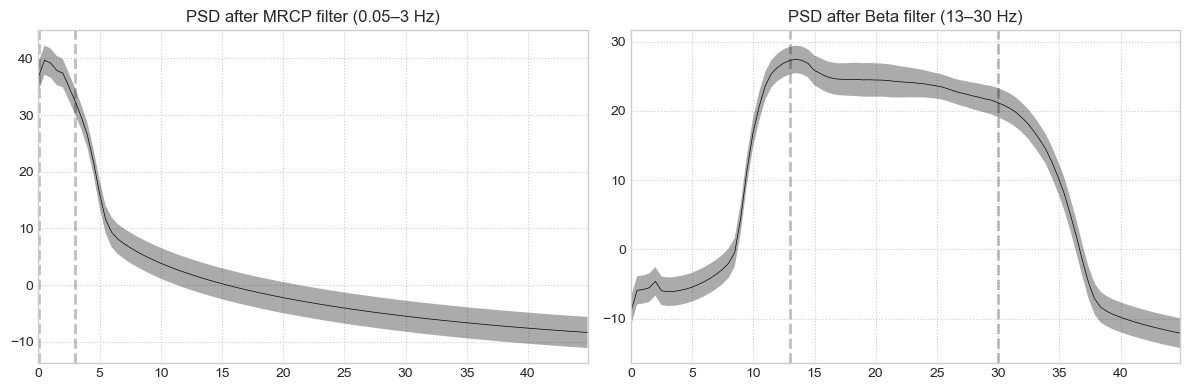

In [14]:
import matplotlib.pyplot as plt

def plot_psd_check(epochs_mrcp, epochs_beta, fmax=45):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    epochs_mrcp.copy().pick("eeg").plot_psd(
        fmax=fmax, average=True, ax=axs[0], show=False
    )
    axs[0].set_title("PSD after MRCP filter (0.05–3 Hz)")

    epochs_beta.copy().pick("eeg").plot_psd(
        fmax=fmax, average=True, ax=axs[1], show=False
    )
    axs[1].set_title("PSD after Beta filter (13–30 Hz)")

    plt.tight_layout()
    plt.show()

plot_psd_check(epochs_mrcp, epochs_beta)


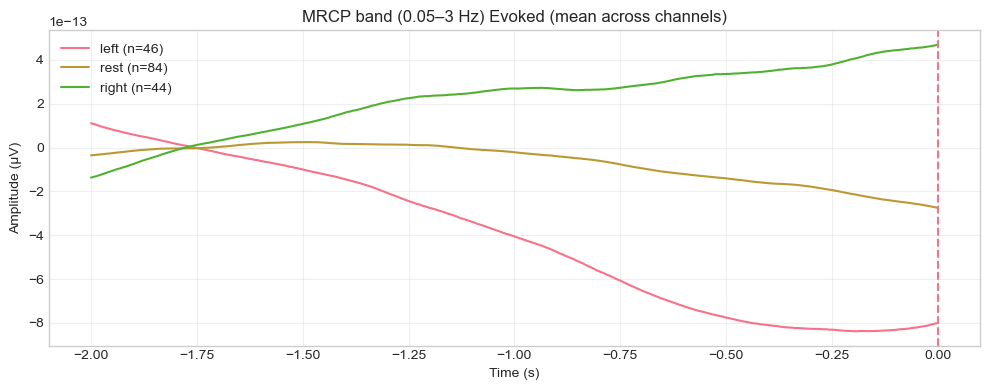

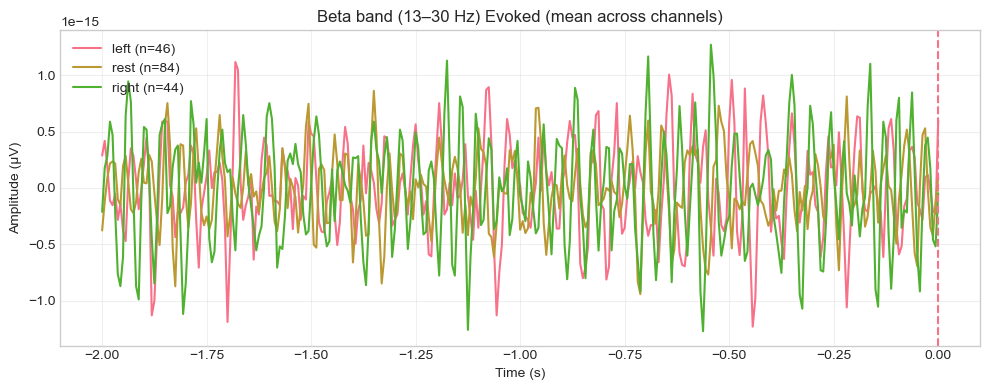

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evoked_by_class(epochs, title_prefix=""):
    classes = sorted(list(epochs.event_id.keys()))
    fig, ax = plt.subplots(figsize=(10, 4))

    for cls in classes:
        if len(epochs[cls]) == 0:
            continue
        evoked = epochs[cls].average()
        # Global mean across channels (quick visualization)
        y = evoked.data.mean(axis=0) * 1e6  # µV
        ax.plot(evoked.times, y, label=f"{cls} (n={len(epochs[cls])})")

    ax.axvline(0, linestyle="--")
    ax.set_title(f"{title_prefix} Evoked (mean across channels)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (µV)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_evoked_by_class(epochs_mrcp, title_prefix="MRCP band (0.05–3 Hz)")
plot_evoked_by_class(epochs_beta, title_prefix="Beta band (13–30 Hz)")


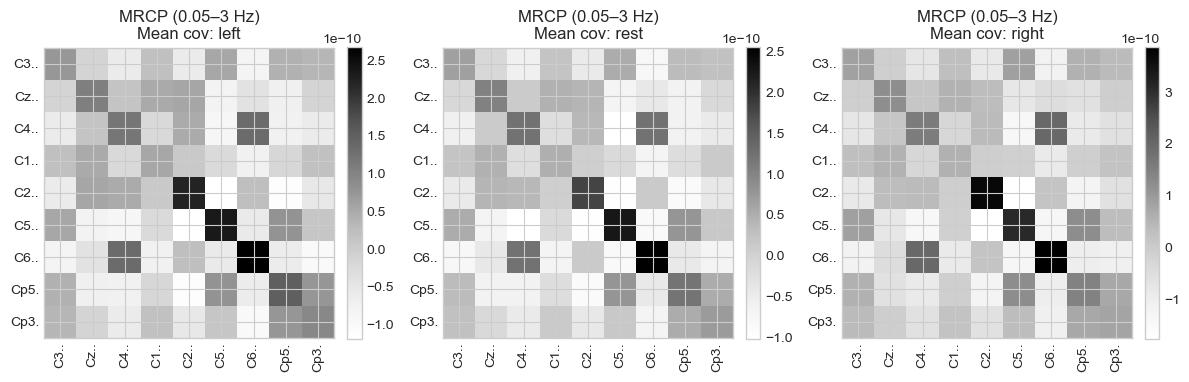

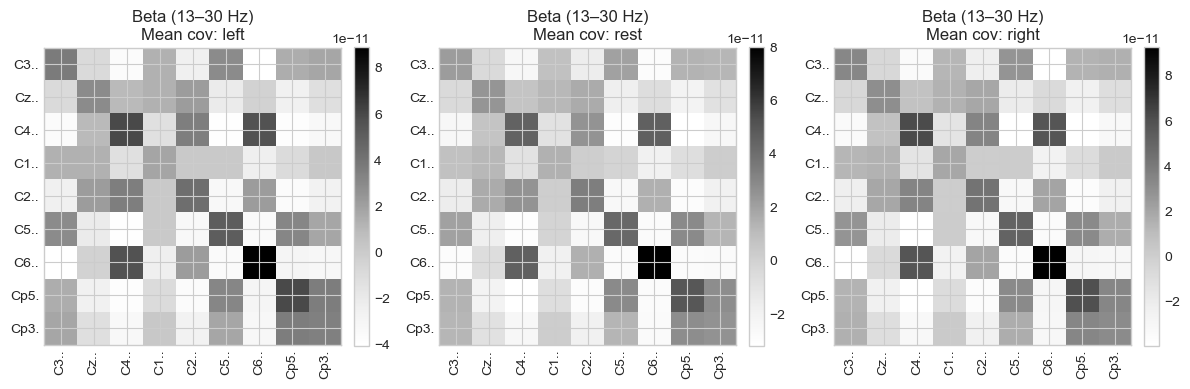

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def class_mean_cov(covs, labels, cls):
    X = covs[labels == cls]
    if len(X) == 0:
        return None
    return X.mean(axis=0)

def plot_mean_covariances(covs, labels, ch_names, title=""):
    classes = sorted(np.unique(labels))
    n = len(classes)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4))

    if n == 1:
        axs = [axs]

    for ax, cls in zip(axs, classes):
        M = class_mean_cov(covs, labels, cls)
        im = ax.imshow(M, aspect="equal")
        ax.set_title(f"{title}\nMean cov: {cls}")
        ax.set_xticks(range(len(ch_names)))
        ax.set_yticks(range(len(ch_names)))
        ax.set_xticklabels(ch_names, rotation=90)
        ax.set_yticklabels(ch_names)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

ch_names = epochs_beta.ch_names
plot_mean_covariances(covs_mrcp, labels, ch_names, title="MRCP (0.05–3 Hz)")
plot_mean_covariances(covs_beta, labels, ch_names, title="Beta (13–30 Hz)")


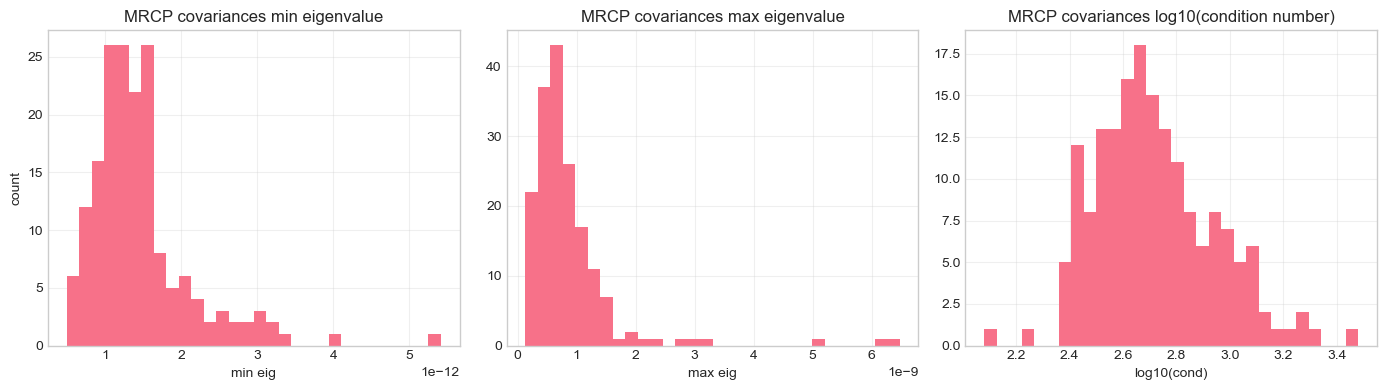

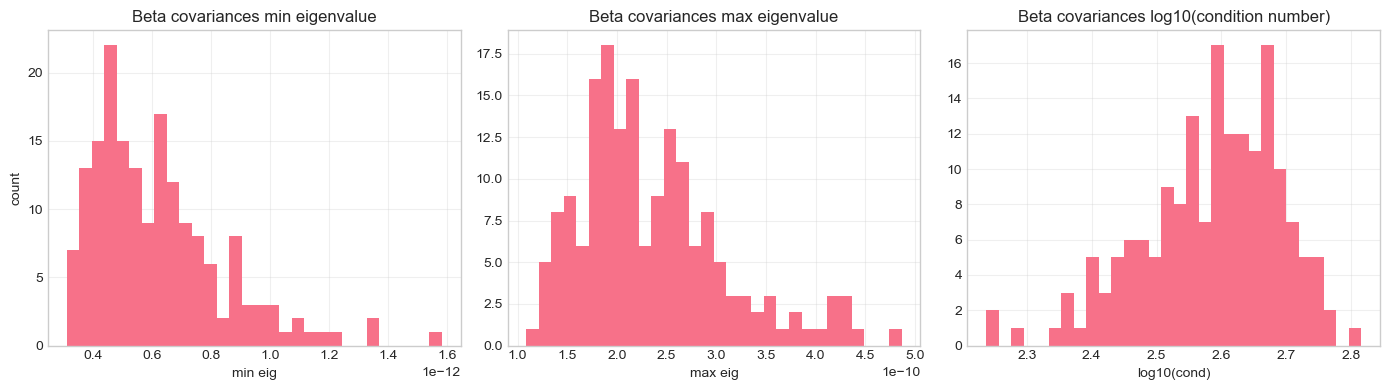

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spd_diagnostics(covs, title=""):
    eig_min = np.array([np.min(np.linalg.eigvalsh(C)) for C in covs])
    eig_max = np.array([np.max(np.linalg.eigvalsh(C)) for C in covs])
    conds = np.array([np.linalg.cond(C) for C in covs])

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].hist(eig_min, bins=30)
    axs[0].set_title(f"{title} min eigenvalue")
    axs[0].set_xlabel("min eig")
    axs[0].set_ylabel("count")
    axs[0].grid(True, alpha=0.3)

    axs[1].hist(eig_max, bins=30)
    axs[1].set_title(f"{title} max eigenvalue")
    axs[1].set_xlabel("max eig")
    axs[1].grid(True, alpha=0.3)

    axs[2].hist(np.log10(conds + 1e-12), bins=30)
    axs[2].set_title(f"{title} log10(condition number)")
    axs[2].set_xlabel("log10(cond)")
    axs[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_spd_diagnostics(covs_mrcp, title="MRCP covariances")
plot_spd_diagnostics(covs_beta, title="Beta covariances")


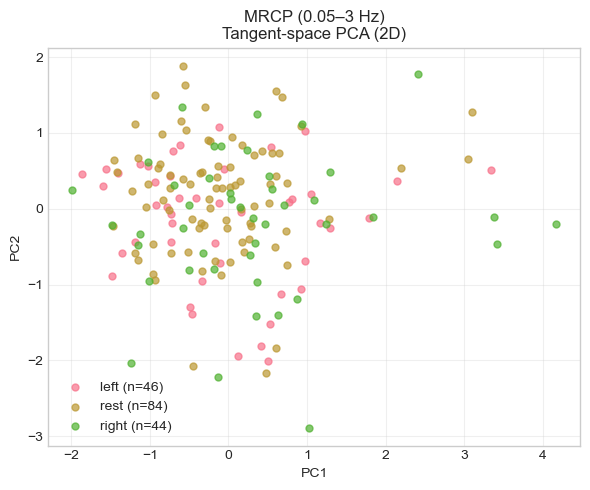

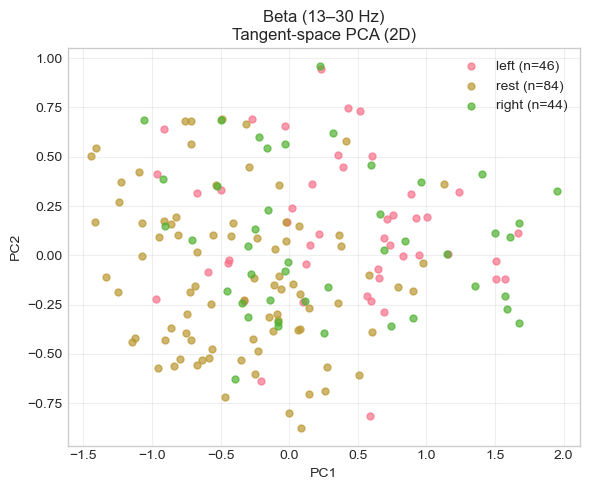

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def sqrtm_psd(A):
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, 1e-12)
    return V @ np.diag(np.sqrt(w)) @ V.T

def invsqrtm_psd(A):
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, 1e-12)
    return V @ np.diag(1.0 / np.sqrt(w)) @ V.T

def logm_spd(A):
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, 1e-12)
    return V @ np.diag(np.log(w)) @ V.T

def mean_euclid(covs):
    return covs.mean(axis=0)

def tangent_features(covs, ref):
    """
    Log map at ref:
      T_i = log( ref^{-1/2} C_i ref^{-1/2} )
    Then vectorize symmetric matrix (upper triangle).
    """
    iS = invsqrtm_psd(ref)
    feats = []
    for C in covs:
        T = logm_spd(iS @ C @ iS)
        feats.append(sym_vec(T))
    return np.array(feats)

def sym_vec(S):
    # upper triangle vectorization (including diagonal)
    idx = np.triu_indices_from(S)
    v = S[idx]
    return v

def pca_2d(X):
    Xc = X - X.mean(axis=0, keepdims=True)
    U, s, Vt = np.linalg.svd(Xc, full_matrices=False)
    Z = Xc @ Vt[:2].T
    return Z

def plot_tangent_pca(covs, labels, title=""):
    ref = mean_euclid(covs)
    X = tangent_features(covs, ref)
    Z = pca_2d(X)

    classes = sorted(np.unique(labels))
    fig, ax = plt.subplots(figsize=(6, 5))

    for cls in classes:
        m = labels == cls
        ax.scatter(Z[m, 0], Z[m, 1], s=25, alpha=0.7, label=f"{cls} (n={m.sum()})")

    ax.set_title(f"{title}\nTangent-space PCA (2D)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_tangent_pca(covs_mrcp, labels, title="MRCP (0.05–3 Hz)")
plot_tangent_pca(covs_beta, labels, title="Beta (13–30 Hz)")


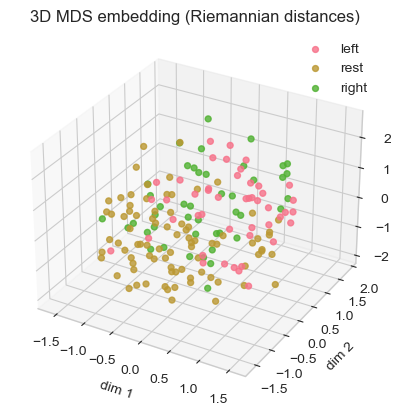

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder

# ---------- Riemannian distance for SPD ----------
def invsqrtm_psd(A, eps=1e-12):
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, eps)
    return V @ np.diag(1.0 / np.sqrt(w)) @ V.T

def riemann_distance(A, B, eps=1e-12):
    # d(A,B)=||log(A^{-1/2} B A^{-1/2})||_F
    A_invsqrt = invsqrtm_psd(A, eps=eps)
    C = A_invsqrt @ B @ A_invsqrt
    w = np.linalg.eigvalsh(C)
    w = np.maximum(w, eps)
    return np.sqrt(np.sum(np.log(w)**2))

def pairwise_riemann_distances(covs, max_points=600, seed=0):
    """
    Computes NxN distance matrix; optionally subsamples points for speed.
    """
    rng = np.random.default_rng(seed)
    n = covs.shape[0]
    if n > max_points:
        idx = rng.choice(n, size=max_points, replace=False)
        covs = covs[idx]
    else:
        idx = np.arange(n)

    m = covs.shape[0]
    D = np.zeros((m, m), dtype=float)
    for i in range(m):
        D[i, i] = 0.0
        for j in range(i + 1, m):
            d = riemann_distance(covs[i], covs[j])
            D[i, j] = d
            D[j, i] = d
    return D, idx

# ---------- 3D plot ----------
def plot_mds_3d(covs, labels, title="3D MDS embedding (Riemannian distances)", max_points=600):
    D, idx = pairwise_riemann_distances(covs, max_points=max_points)
    labels_sub = np.asarray(labels)[idx]

    # MDS on precomputed distances
    mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0, normalized_stress="auto")
    X3 = mds.fit_transform(D)

    # Encode labels for coloring
    le = LabelEncoder()
    y = le.fit_transform(labels_sub)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for k, name in enumerate(le.classes_):
        mask = (y == k)
        ax.scatter(X3[mask, 0], X3[mask, 1], X3[mask, 2], label=name, s=18, alpha=0.8)

    ax.set_title(title)
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    ax.set_zlabel("dim 3")
    ax.legend()
    plt.show()

# Example usage:
plot_mds_3d(covs_beta, labels, max_points=600)
